In [1]:
import numpy as np
import pandas as pd
import operator
import os
import string
import re
import random
import sys
import platform

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from transformers import Blip2Processor, Blip2ForConditionalGeneration

from tqdm.auto import tqdm

In [7]:
device = "cuda:3"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")
model.to(device, torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [8]:
import os
import json

from torchvision.datasets import ImageFolder
from natsort import natsorted
from datetime import datetime

In [10]:
with open(os.path.join("./", 'classes.json'), 'r') as j:
    class_names = json.loads(j.read())

In [11]:
class_names

['Buildings', 'Forests', 'Glacier', 'Mountains', 'Sea', 'Street']

In [12]:
img_path = f"./Scene/0/{238}.jpg"

In [80]:
image = Image.open(img_path).convert('RGB')
prompt1 = "Please describe the scene."
prompt2 = "Please describe the image."

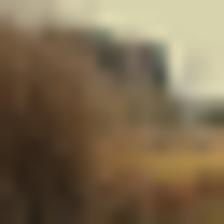

In [81]:
image

In [96]:
inputs = processor(images=image, text=[prompt1], return_tensors="pt").to(device)

In [97]:
generated_ids = model.generate(**inputs)

In [98]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [99]:
generated_text

'a sand beach with a sand beach and a sand'

In [100]:
output = zeroshot_classifier(generated_text, classes_verbalized, hypothesis_template=hypothesis_template, multi_label=False)
print(f"{generated_text} : {output['labels'][0]}")

a sand beach with a sand beach and a sand : Sea


In [35]:
text2index('a buildings')

0

In [59]:
def text2index(gen_text):
    classes = ['Buildings', 'Forests', 'Glacier', 'Mountains', 'Sea', 'Street']
    for idx, text in enumerate(classes):
        if text == gen_text:
            return idx

In [56]:
from transformers import pipeline
text = "Angela Merkel is a politician in Germany and leader of the CDU"
hypothesis_template = "{}"
classes_verbalized = ['Buildings', 'Forests', 'Glacier', 'Mountains', 'Sea', 'Street']
zeroshot_classifier = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0")  # change the model identifier here
output = zeroshot_classifier(text, classes_verbalized, hypothesis_template=hypothesis_template, multi_label=False)
print(output)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'sequence': 'Angela Merkel is a politician in Germany and leader of the CDU', 'labels': ['Sea', 'Buildings', 'Street', 'Mountains', 'Forests', 'Glacier'], 'scores': [0.2592664659023285, 0.22068199515342712, 0.1661624312400818, 0.148606538772583, 0.11095580458641052, 0.09432673454284668]}


In [64]:
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

img_nums = 8100
submission = dict({'id_idx': [], 'label': []})

for idx in range(img_nums):
    img_path = f"./Scene/0/{idx}.jpg"
    image = Image.open(img_path).convert('RGB')
    prompt = "Please describe the scene."
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
    output = zeroshot_classifier(generated_text, classes_verbalized, hypothesis_template=hypothesis_template, multi_label=False)
    #print(f"{generated_text} : {output['labels'][0]}")
    submission['label'] += [text2index(output['labels'][0])]
    
    if (idx+1)%100 == 0:
        file_name = f'submission_{current_time}.csv'
        submission['id_idx'] = list(range(len(submission['label'])))
        pd.DataFrame(submission).to_csv(os.path.join("./submissions/", file_name), index=False)
        print(idx+1)

100
200
300
400
500
600


KeyboardInterrupt: 